In [1]:
%autosave 60

import os
import sys
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from google.colab import drive
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import cv2

Autosaving every 60 seconds


In [2]:
drive.mount('/content/drive/')
dataset_folder = 'drive/MyDrive/datasets/diver'
#dataset_folder = 'C:/Users/lesni/Desktop/segmentation dataset/train_val/train_val'


images_folder = "/images"
masks_folder = "/processed"
masks_format = "png"

def load_data(max_num):
  imgs = []
  msks = []

  count = 0

  for fname in os.listdir(dataset_folder + images_folder):
    if count >= max_num:
      break
    count += 1

    img = cv2.imread(os.path.join(dataset_folder + images_folder, fname))
    msk = cv2.imread(os.path.join(dataset_folder + masks_folder, fname[:-3] + masks_format))

    if img is not None and msk is not None:
      imgs.append(img)
      msks.append(msk)

  return [imgs, msks]

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
img_size = 512

images, masks = load_data(100)

for i in range(len(images)):
  images[i] = cv2.resize(images[i], (img_size,img_size))
  masks[i] = cv2.resize(masks[i], (img_size,img_size))

images = np.array(images)
masks = np.array(masks)

In [4]:
images = images/255.
masks = masks/255.

In [5]:
def delete_noise(masks):
    for i in range(masks.shape[0]):
        for j in range(masks.shape[1]):
            for k in range(masks.shape[2]):
                for m in range(masks.shape[3]):
                    if (masks[i,j,k,m] != 1.):
                        masks[i,j,k,m] = 0.

In [6]:
delete_noise(masks)

In [7]:
NUM_CLASSES = 8

c1 = np.unique(masks[:,:,:,0])
c2 = np.unique(masks[:,:,:,1])
c3 = np.unique(masks[:,:,:,2])

print(c1,c2,c3)

[0. 1.] [0. 1.] [0. 1.]


In [8]:
colors = [
    [0,0,0],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1],
]

def cat_masks(masks):
    masks_for_cat = np.empty([masks.shape[0], masks.shape[1], masks.shape[2]], 'float')

    for i in range(masks.shape[0]):
        for j in range(masks.shape[1]):
            for k in range(masks.shape[2]):
                masks_for_cat[i,j,k] = colors.index(masks[i,j,k].tolist())

    masks_cat = to_categorical(masks_for_cat, NUM_CLASSES)

    return masks_cat

def reverse_cat(masks_cat):

    masks = np.empty(shape=[masks_cat.shape[0],masks_cat.shape[1],masks_cat.shape[2],3])

    for i in range(masks_cat.shape[0]):
        for j in range(masks_cat.shape[1]):
            for k in range(masks_cat.shape[2]):
                ind = np.argmax(masks_cat[i,j,k])
                masks[i,j,k] = np.array(colors[ind])

    return masks

In [9]:
masks_cat = cat_masks(masks)

print(masks_cat.shape)

(100, 512, 512, 8)


In [10]:
def down_conv(prev_layer, num_layers,  kernel_size=(3,3), padding="same", strides=1, activation="relu"):
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(prev_layer)
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conv)
  pool = MaxPool2D((2,2), (2,2))(conv)

  return [conv, pool]

def up_conv(prev_layer, skip_layer, num_layers,  kernel_size=(3,3), padding="same", strides=1, activation="relu"):
  upsamp = UpSampling2D((2,2))(prev_layer)
  conc = Concatenate()([upsamp, skip_layer])
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conc)
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conv)

  return conv

def bootle_neck(prev_layer, num_layers,  kernel_size=(3,3), padding="same", strides=1, activation="relu"):
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(prev_layer)
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conv)

  return conv

def reduce_layers(layer, num_classes):
  return Conv2D(num_classes, (1,1), padding="same", activation="softmax")(layer)

In [11]:


input = keras.layers.Input((img_size,img_size,3))
conv1, pool1 = down_conv(input, 16)
conv2, pool2 = down_conv(pool1, 32)
conv3, pool3 = down_conv(pool2, 64)
conv4, pool4 = down_conv(pool3, 128)

bneck = bootle_neck(pool4, 256)

up1 = up_conv(bneck, conv4, 128)
up2 = up_conv(up1, conv3, 64)
up3 = up_conv(up2, conv2, 32)
up4 = up_conv(up3, conv1, 16)

output = reduce_layers(up4, NUM_CLASSES)

model = keras.models.Model(input, output)

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

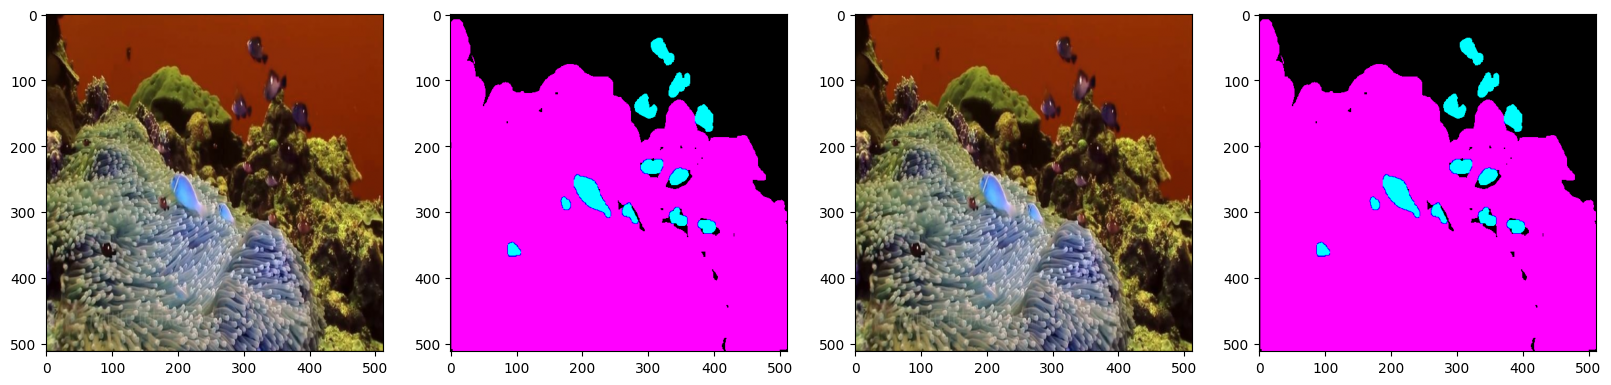

In [12]:
plt.figure(figsize=(20,10))

plt.subplot(141)
plt.imshow(images[0])
plt.subplot(142)
plt.imshow(masks[0])

plt.subplot(143)
plt.imshow(images[0])
plt.subplot(144)
plt.imshow(masks[0])

plt.show()


In [13]:
model.fit(images, masks_cat, epochs=500, validation_split=0.2)

Epoch 1/500
3/3 [==============================] - 67s 14s/step - loss: 2.0584 - accuracy: 0.2473 - val_loss: 1.9210 - val_accuracy: 0.3134
Epoch 2/500
3/3 [==============================] - 4s 1s/step - loss: 1.9874 - accuracy: 0.3866 - val_loss: 1.8577 - val_accuracy: 0.2689
Epoch 3/500
3/3 [==============================] - 4s 1s/step - loss: 1.8496 - accuracy: 0.2644 - val_loss: 1.8514 - val_accuracy: 0.3830
Epoch 4/500
3/3 [==============================] - 4s 1s/step - loss: 1.7756 - accuracy: 0.3001 - val_loss: 1.7706 - val_accuracy: 0.3862
Epoch 5/500
3/3 [==============================] - 4s 1s/step - loss: 1.7251 - accuracy: 0.3019 - val_loss: 1.6680 - val_accuracy: 0.3842
Epoch 6/500
3/3 [==============================] - 4s 1s/step - loss: 1.5976 - accuracy: 0.3538 - val_loss: 1.6608 - val_accuracy: 0.3295
Epoch 7/500
3/3 [==============================] - 4s 1s/step - loss: 1.5784 - accuracy: 0.4000 - val_loss: 1.7038 - val_accuracy: 0.3297
Epoch 8/500
3/3 [===============

1/1 [==============================] - 0s 28ms/step


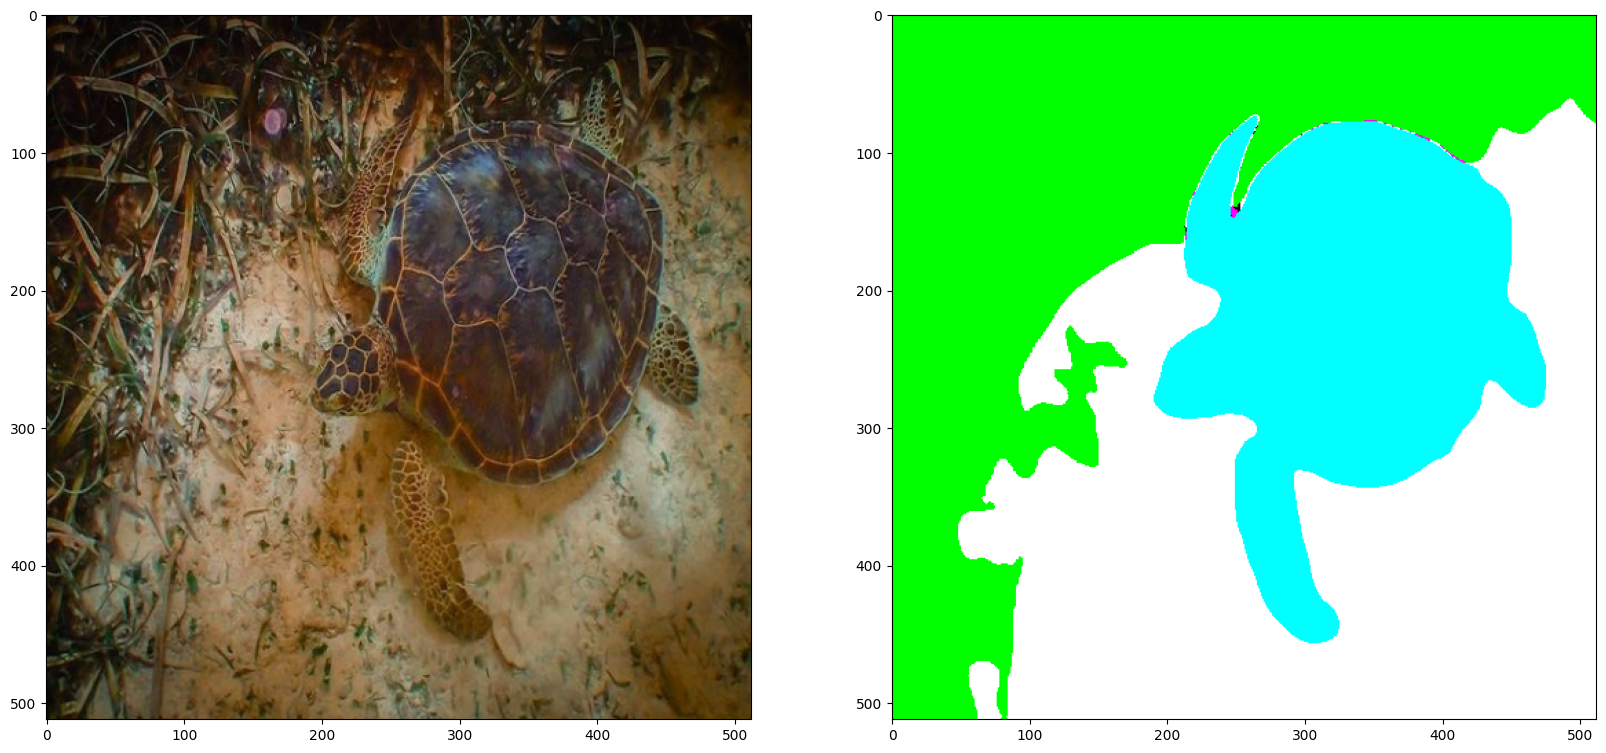

In [17]:
num = 40

pred = model.predict(np.array([images[num]]))

pred_mask = reverse_cat(pred)

plt.figure(figsize=[20,10])
plt.subplot(121)
plt.imshow(images[num])
plt.subplot(122)
plt.imshow(pred_mask[0])
plt.show()

In [18]:
model.save('drive/MyDrive/models/mult_class.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
